### In this project, I apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation.

This project was completed as an assignment for my Reinforcement Learning course at LSE.


Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from sklearn.neural_network import MLPRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation
from IPython.display import HTML

from copy import deepcopy
import pickle

In [2]:
env = gym.make('CartPole-v1')
print(env.action_space)
print(env.observation_space)


Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Step 1: Offline dataset Generation

In [3]:
def action(angle):
    # agent follows the deterministic policy or the uniform random policy with equal probability
    if np.random.binomial(1, 0.5):
        if angle < 0:
            return 0
        else:
            return 1
    else:
        return np.random.binomial(1, 0.5)

In [4]:
np.random.seed(1)
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()

#env.seed(1)  # seems cartpole doesn't support seeding

episodes = 100
data = np.array([])
for i in range(episodes):
    obs = env.reset()
    obs = obs[0]
    done = False
    rewards = 0.0
    while not done and rewards < 500:
        s = obs
        env.render()
        a = action(obs[2])
        obs, r, done, info, _ = env.step(a)

        # log (s, a, r, s') tuple in the dataset
        data = np.append(data, {'state': s, 'action': a, 'reward': r, 'next': obs, 'is_done': done})

        rewards += r
    print('Episode:', i, 'Rewards:', rewards)
    print('Observations:', obs)

print(data.shape)

Episode: 0 Rewards: 41.0
Observations: [-0.19443645 -0.9683099   0.23768997  1.3670146 ]
Episode: 1 Rewards: 74.0
Observations: [-0.30781272 -1.169611    0.22699024  1.5072786 ]
Episode: 2 Rewards: 37.0
Observations: [ 0.14660187  0.9762831  -0.24041641 -1.4729745 ]
Episode: 3 Rewards: 14.0
Observations: [ 0.16723831  0.81271076 -0.21971834 -1.3951291 ]
Episode: 4 Rewards: 46.0
Observations: [-0.33960378 -1.5130842   0.2146998   1.6527153 ]
Episode: 5 Rewards: 57.0
Observations: [-0.02486062 -0.19311287  0.22322974  0.73801625]
Episode: 6 Rewards: 36.0
Observations: [ 0.03769971  0.05370085 -0.22018519 -1.0883368 ]
Episode: 7 Rewards: 62.0
Observations: [ 0.11535356  0.05209154 -0.21918651 -0.27552098]
Episode: 8 Rewards: 31.0
Observations: [ 0.11683451  1.7313087  -0.23374878 -2.7260723 ]
Episode: 9 Rewards: 30.0
Observations: [ 0.16546635  0.03560429 -0.21027382 -0.58476573]
Episode: 10 Rewards: 27.0
Observations: [ 0.11976422  0.54925215 -0.21115501 -0.90451956]
Episode: 11 Rewards:

### Step 2: Fitted Q iteration Implementation

In [5]:
K = 20
gammas = [0.95, 0.99, 1]

# separate datasets for each action for training the approximators
X_l = np.array([row['state'] for row in data if row['action'] == 0])
X_r = np.array([row['state'] for row in data if row['action'] == 1])

print(X_l.shape, X_r.shape)

(2203, 4) (2238, 4)


In [6]:
# store 2-tuples of models
# Structure: (left_action_qfunc, right_action_qfunc)
all_models = {}
for gamma in gammas:
    models = []
    print(f"Training models with gamma = {gamma}")

    for i in range(K):
        if i == 0:
            l_model = MLPRegressor(max_iter=500)  # initialse new model instance for the first iteration
            r_model = MLPRegressor(max_iter=500)
        else:
            l_model = deepcopy(models[i-1][0])  # use the trained model from the previous iteration
            r_model = deepcopy(models[i-1][1])
        
        # first compute the target for each state action pair to build training set
        y_l = np.array([])
        y_r = np.array([])
        for row in data:    
            imm_reward = row['reward']

            # initial Q_function and terminal states have next-state reward of 0
            if i == 0 or row['is_done']:  
                    next_reward = 0
            else:
                # The TD target here uses off-policy greedy selection of next action (like in qlearning)
                q_next_l = l_model.predict(row['next'].reshape(1, -1))
                q_next_r = r_model.predict(row['next'].reshape(1, -1))
                
                if q_next_l > q_next_r:
                    next_reward = gamma*l_model.predict(row['next'].reshape(1, -1))
                else:
                    next_reward = gamma*r_model.predict(row['next'].reshape(1, -1))

            if row['action'] == 0:
                y_l = np.append(y_l, imm_reward + next_reward)
            else:
                y_r = np.append(y_r, imm_reward + next_reward)
        

        # train Q-function approximators
        # Structure (predictor, target) = (state, reward)
        assert X_l.shape[0] == y_l.shape[0]

        # new model instances to reset the weights
        l_model = MLPRegressor(max_iter=500)
        r_model = MLPRegressor(max_iter=500)

        l_model.fit(X_l, y_l)
        r_model.fit(X_r, y_r)

        print(f"Finished training iteration {i+1}")
        models.append([l_model, r_model])
    
    all_models[gamma] = models


# checking model uniqueness
assert any(models[1][0].predict(X_l) != models[0][0].predict(X_l))
assert any(models[0][0].predict(X_l) != models[0][1].predict(X_l))
print("Done")

Training models with gamma = 0.95
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 4


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 5


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 6


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 7


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20
Training models with gamma = 0.99
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 4
Finished training iteration 5


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 6


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 7


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20
Training models with gamma = 1
Finished training iteration 1
Finished training iteration 2
Finished training iteration 3


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 4


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 5


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 6


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 7


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 8


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 9


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 10


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 11


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 12


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 13


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 14


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 15


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 16


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 17


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 18


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 19


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training iteration 20
Done


c:\Users\joluw\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Step 3: Policy Evaluation using Monte Carlo

In [7]:
def fqi_policy(state, l_model, r_model):
    # choose the action which maximises Q-function approximator
    if l_model.predict(state) > r_model.predict(state):
        return 0
    else:
        return 1

In [8]:
np.random.seed(1)
env = gym.make('CartPole-v1', render_mode="rgb_array")
results = []

# so it doesn't run forever
MAX_REWARDS = 5000

for gamma, models in all_models.items():
    print(f"Evaluating gamma = {gamma}")
    
    for i in range(len(models)):
        env.reset()
        episodes = 1000
        rewards_mc = []
        l_model, r_model = models[i][0], models[i][1] 
        for j in range(episodes):
            obs = env.reset()
            obs = obs[0]
            done = False
            rewards = 0.0
            while not done and rewards < MAX_REWARDS:
                a = fqi_policy(obs.reshape(1, -1), l_model, r_model)  # pass the current state to the Q-function approximators. 
                obs, r, done, info, _ = env.step(a)

                rewards += r

            rewards_mc.append(rewards)
        
        avg_reward = np.mean(rewards_mc)
        max_reward = np.max(rewards_mc)
        result = [gamma, i+1, avg_reward, max_reward]
        print(f"Average and Max reward for gamma={result[0]}, fqi_teration={result[1]}: ({result[2]}, {result[3]})")
        
        results.append(result)

        # write current results to a file to prevent loss of progress (this loop takes ages)
        path = 'interm_results.pkl'
        with open(path, 'wb') as file:
            pickle.dump(results, file)
        

        
results_df = pd.DataFrame(results, columns=['gamma', 'fqi_iteration', 'avg_reward', 'max_reward'])


Evaluating gamma = 0.95
Average and Max reward for gamma=0.95, fqi_teration=1: (64.281, 221.0)
Average and Max reward for gamma=0.95, fqi_teration=2: (16.247, 36.0)
Average and Max reward for gamma=0.95, fqi_teration=3: (23.807, 46.0)
Average and Max reward for gamma=0.95, fqi_teration=4: (155.079, 559.0)
Average and Max reward for gamma=0.95, fqi_teration=5: (216.226, 455.0)
Average and Max reward for gamma=0.95, fqi_teration=6: (205.479, 1168.0)
Average and Max reward for gamma=0.95, fqi_teration=7: (263.341, 438.0)
Average and Max reward for gamma=0.95, fqi_teration=8: (254.676, 2616.0)
Average and Max reward for gamma=0.95, fqi_teration=9: (277.889, 823.0)
Average and Max reward for gamma=0.95, fqi_teration=10: (292.732, 1945.0)
Average and Max reward for gamma=0.95, fqi_teration=11: (331.852, 983.0)
Average and Max reward for gamma=0.95, fqi_teration=12: (219.379, 536.0)
Average and Max reward for gamma=0.95, fqi_teration=13: (171.073, 260.0)
Average and Max reward for gamma=0.95,

In [9]:
# save results to csv
filename = 'results_df.csv'
with open(path, 'w') as file:
            results_df.to_csv(filename, index=None)

### Results and Conclusion

Using Neural Fitted Q-iteration, we trained several RL agents to try to complete the Cartpole-V1 challenge. Note that there are several sources of randomness in this code. The reward estimates vary on each run, so the configuration of the best model in terms of reward may differ each time the notebook is run. Also, there is no guarantee that the Q-function approximators all converged to global minima. In fact, after the first few training rounds (typically by the third), the Q-function approximators failed to converge in 500 iterations.

The model with the highest average reward was achieved with parameter $\gamma = 0.95$ on the 15th training round. Using this policy, the estimated total reward by averaging across 1000 episodes was 5000, which is also the max rewards that I allowed. This suggests that said policy solves the problem, since the average reward far exceeds 500. This is demonstrated below by animation. 

The second best model ($\gamma=1$, training round 10) also beats the challenge with an average reward of 742.

In the plot below we can see that as the number of iterations increases, the average reward tends to stop increasing and fluctuates. The fact that the Q-function approximators didn't converge in the latter training rounds is probably contributing to this. There is no obvious best $\gamma$ value out of the few we tested; any value reasonably close to 1 should be suitable.

<br>

Ways to improve the results include the following (non-exhaustive):
- Increasing the maximum number of iterations before terminiating training of the neural networks.
- More episodes in offline training dataset.
- Online updates of the training set based on derived Q-functions at each iteration.


A plot is included without the best model, since the reward=5000 value makes the plot hard to read.

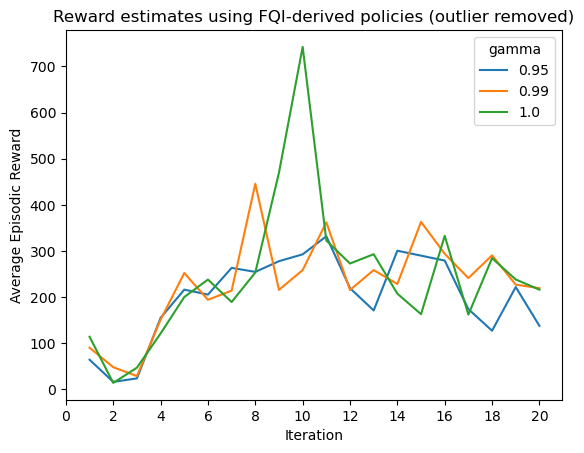

In [22]:
sns.lineplot(x='fqi_iteration', y='avg_reward', hue='gamma', data=results_df.drop(14), palette='tab10')
plt.title("Reward estimates using FQI-derived policies (outlier removed)")
plt.xlabel("Iteration")
plt.ylabel("Average Episodic Reward")

plt.gca().set_xticks(np.arange(0, 21, 2))

plt.show()

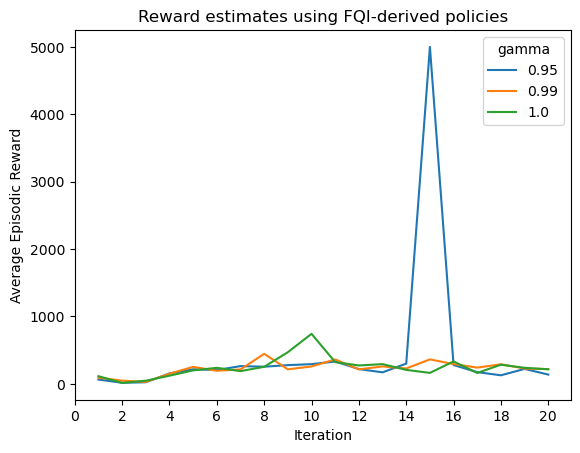

In [23]:
sns.lineplot(x='fqi_iteration', y='avg_reward', hue='gamma', data=results_df, palette='tab10')
plt.title("Reward estimates using FQI-derived policies")
plt.xlabel("Iteration")
plt.ylabel("Average Episodic Reward")

plt.gca().set_xticks(np.arange(0, 21, 2))

plt.show()

In [11]:
results_df.sort_values('avg_reward', ascending=False)

,gamma,fqi_iteration,avg_reward,max_reward
14,0.95,15,5000.000,5000.0
49,1.00,10,742.332,5000.0
48,1.00,9,469.896,5000.0
27,0.99,8,445.750,5000.0
34,0.99,15,363.062,990.0
30,0.99,11,362.210,922.0
55,1.00,16,332.781,1164.0
10,0.95,11,331.852,983.0
50,1.00,11,322.656,1078.0
13,0.95,14,300.606,560.0


## Animation of best model

Please open HW7.html to run the animation.

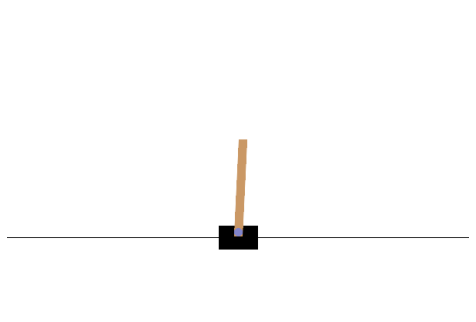

In [20]:
# create animation with the best model
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
l_model = all_models[0.95][14][0]
r_model = all_models[0.95][14][1]

obs = env.reset()

frames = []
obs = obs[0]
done = False
rewards = 0.0
while not done and rewards < 500:
    frames.append(env.render())
    a = fqi_policy(obs.reshape(1, -1), l_model, r_model)  # pass the current state to the Q-function approximators. 
    obs, r, done, info, _ = env.step(a)

    rewards += r

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())